In [1]:
import numpy as np
import pandas as pd
import math

df = pd.read_csv("filtered_protacs.csv")
f = open("dc50_labels.txt", "r")
lines = f.readlines()
refined_lines = []
for l in lines:
    l = l.replace("(n/a)", "")
    l = l.replace("\n", "")
    l = l.replace(">", "")
    l = l.replace("<", "")
    l = l.replace("=", "")
    refined_lines.append(l)
print(len(refined_lines))

final_labels = []
for l in refined_lines:
    arr = l.split('/')
    if len(arr) > 1:
        smallest_so_far = 999999
        for el in arr:
            if el == "":
                continue
            if el.find("~") > 0 or el.find("-") > 0:
                continue
            el = float(el)
            if el < smallest_so_far:
                smallest_so_far = el
        final_labels.append(smallest_so_far)
    else:
        final_labels.append(arr[0])
print(len(final_labels))
target_proteins = np.array(list(df["Target Protein"]))
e3_targets = np.array(list(df["E3 Target"]))
warheads = np.array(list(df["Warhead"]))
linkers = np.array(list(df["Linker"]))
e3_ligands = np.array(list(df["E3 Ligand"]))

labeled_indices = []
for i, val in enumerate(final_labels):
    val = str (val)
    if val == "":
        continue
    else:
        labeled_indices.append(i)

target_proteins = target_proteins[labeled_indices]
e3_targets = e3_targets[labeled_indices]
warheads = warheads[labeled_indices]
linkers = linkers[labeled_indices]
e3_ligands = e3_ligands[labeled_indices]
final_labels = np.array(final_labels)
my_labels = final_labels[labeled_indices]

print(len(target_proteins))
print(len(e3_targets))
print(len(warheads))
print(len(linkers))
print(len(e3_ligands))
print(len(my_labels))


5372
5372
903
903
903
903
903
903


In [2]:
from tqdm import tqdm as tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
from sklearn.preprocessing import normalize
from itertools import product

def get_fingerprint(smiles, r=3, nBits=1024):
    compound = Chem.MolFromSmiles(smiles.strip())
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(compound, r, nBits=nBits)
    m = np.zeros((0, ), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fingerprint,m)
    return m


def sequence_to_kmer(protein_seq, k):
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range(0, len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range(0, len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct, ind))
    
    V=np.zeros(int((math.pow(7,k))))
    try:
        for j in range(0, len(protein_seq)-k+1):
            kmer=protein_seq[j:j+k]
            c=''
            for l in range(0, k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]] += 1
    except:
        count={'1':0,'2':0,'3':0, '4':0, '5':0,'6':0,'7':0}
        for q in range(0,len(protein_seq)):
            if protein_seq[q]=='A' or protein_seq[q]=='V' or protein_seq[q]=='G':
                count['1']+=1
            if protein_seq[q]=='I' or protein_seq[q]=='L'or protein_seq[q]=='F' or protein_seq[q]=='P':
                count['2']+=1
            if protein_seq[q]=='Y' or protein_seq[q]=='M'or protein_seq[q]=='T' or protein_seq[q]=='S':
                count['3']+=1
            if protein_seq[q]=='H' or protein_seq[q]=='N'or protein_seq[q]=='Q' or protein_seq[q]=='W':
                count['4']+=1
            if protein_seq[q]=='R' or protein_seq[q]=='K':
                count['5']+=1
            if protein_seq[q]=='D' or protein_seq[q]=='E':
                count['6']+=1
            if protein_seq[q]=='C':
                count['7']+=1
        
        value=list(count.values())
        key=list(count.keys())
        maximum_occurence=0
        index=0
        for t in range(0, len(value)):
            if maximum_occurence < value[t]:
                maximum_occurence = value[t]
                index=t
        maximum_occurence = key[index] # group number of maximum occuring group
        for j in range(0, len(protein_seq)-k+1):
            kmer=protein_seq[j:j+k]
            c=''
            for l in range(0, k):
                if kmer[l] not in groups:
                    c += maximum_occurence
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]] += 1
            
        V = V/(len(protein_seq)-1)
        return np.array(V)
    

def get_protein_features(protein_sequence):
    aa=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    f = []
    protein_info = ProteinAnalysis(str(protein_sequence))
    protein_info.molecular_weight()
    amino_acid_percent = protein_info.get_amino_acids_percent()
    dp = []
    for a in aa:
        dp.append(amino_acid_percent[a])
    dp=np.array(dp)
    dp=normalize(np.atleast_2d(dp), norm='l2', copy=True, axis=1, return_norm=False)
    f.extend(dp[0])
    twomer=np.array(sequence_to_kmer(str(protein_sequence), 2))
    twomer=normalize(np.atleast_2d(twomer), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(twomer[0])
    threemer=np.array(sequence_to_kmer(str(protein_sequence), 3))
    threemer=normalize(np.atleast_2d(threemer), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(threemer[0])
    return np.array(f)

In [3]:
labels = []
for m in my_labels:
    if m.find("~") > 0:
        m.split("~")
        m = float (m[0])
        labels.append(m)
    elif m.find("-") > 0:
        m.split("-")
        m = float (m[0])
        labels.append(m)
    else:
        m = float (m)
        labels.append(m)
        

target_protein_features = []
e3_target_features = []
warhead_fingerprints = []
e3_lignad_fingerprints = []
linker_fingerprints = []
for i in tqdm(range(len(target_proteins))):
    p = get_protein_features(target_proteins[i])
    et = get_protein_features(e3_targets[i])
    
    w = get_fingerprint(warheads[i])
    l = get_fingerprint(linkers[i])
    el = get_fingerprint(e3_ligands[i])
        
    target_protein_features.append(p)
    e3_target_features.append(et)
    warhead_fingerprints.append(w)
    e3_lignad_fingerprints.append(el)
    linker_fingerprints.append(l)
    
target_protein_features = np.array(target_protein_features)
e3_target_features = np.array(e3_target_features)
warhead_fingerprints = np.array(warhead_fingerprints)
e3_lignad_fingerprints = np.array(e3_lignad_fingerprints)
linker_fingerprints = np.array(linker_fingerprints)

print(target_protein_features.shape)
print(e3_target_features.shape)
print(warhead_fingerprints.shape)
print(e3_lignad_fingerprints.shape)
print(linker_fingerprints.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 903/903 [00:07<00:00, 119.83it/s]

(903, 412)
(903, 412)
(903, 1024)
(903, 1024)
(903, 1024)


(903, 3896)
[0.32110047 0.10237986 0.32110047 ... 0.         0.         0.        ]


(array([  4.,  23.,  76., 122., 182., 206., 132., 100.,  33.,  25.]),
 array([-4.60517019, -2.99336062, -1.38155106,  0.23025851,  1.84206807,
         3.45387764,  5.0656872 ,  6.67749677,  8.28930633,  9.9011159 ,
        11.51292546]),
 <BarContainer object of 10 artists>)

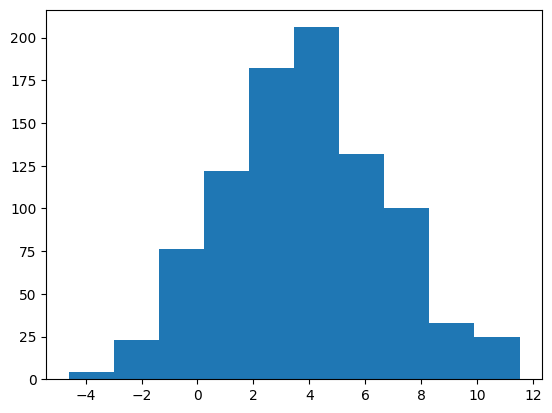

In [4]:
import matplotlib.pyplot as plt

dataset = np.column_stack((target_protein_features, e3_target_features,
                           warhead_fingerprints, e3_lignad_fingerprints, linker_fingerprints))

print(dataset.shape)
print(dataset[0])
labels = np.array(labels)
labels = np.log(labels)
plt.hist(labels)

(903, 2)


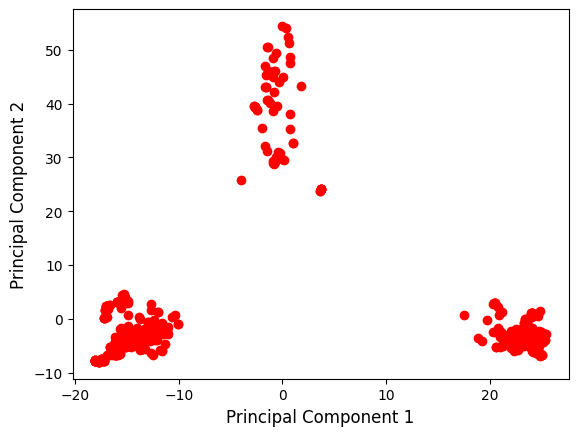

root mean square error:  2.9184494983191724
pearson correlation coefficient:  0.010484883586529482
spearman correlation coefficient:  -0.020087132476476557
r2 score:  -0.1091165474268393


In [5]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

# standardise data
scaler = StandardScaler(with_mean=True, with_std=True)
standardised_dataset = scaler.fit_transform(dataset)

# PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(standardised_dataset)
print(X_reduced.shape)

kf = KFold(n_splits=10)
model = Lasso(alpha=0.1)

plt.scatter(X_reduced[:,0], X_reduced[:,1], color="r", label="data")
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.show()


rmse_scores = []
r2_scores = []
spearman_scores = []
pearson_scores = []
for i, (train_index, test_index) in enumerate(kf.split(X_reduced)):
    X_train, X_test = X_reduced[train_index], X_reduced[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    coeffr, _ = pearsonr(y_test, prediction)
    coeffs, _ = spearmanr(y_test, prediction)
    rmse = math.sqrt(mean_squared_error(y_test, prediction))
    r2 = r2_score(y_test, prediction)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    spearman_scores.append(coeffs)
    pearson_scores.append(coeffr)
                     
                     
print("root mean square error: ", np.array(rmse_scores).mean())
print("pearson correlation coefficient: ", np.array(pearson_scores).mean())
print("spearman correlation coefficient: ", np.array(spearman_scores).mean())
print("r2 score: ", np.array(r2_scores).mean())

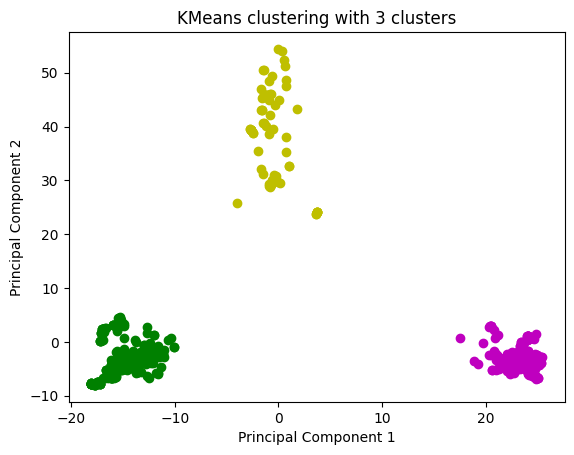

3896


In [6]:
from sklearn.cluster import KMeans

# MIX DATA FROM EACH CLUSTER TO CREATE EACH FOLD

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_reduced)

cluster_0_indices = []
cluster_1_indices = []
cluster_2_indices = []

for i, k in enumerate(kmeans.labels_):
    if k == 0:
        cluster_0_indices.append(i)
    elif k == 1:
        cluster_1_indices.append(i)
    else:
        cluster_2_indices.append(i)

X_0 = X_reduced[cluster_0_indices]
X_1 = X_reduced[cluster_1_indices]
X_2 = X_reduced[cluster_2_indices]

plt.scatter(X_0[:,0], X_0[:,1], color='m', label="cluster 1")
plt.scatter(X_1[:,0], X_1[:,1], color='g', label="cluster 2")
plt.scatter(X_2[:,0], X_2[:,1], color='y', label="cluster 3")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("KMeans clustering with 3 clusters")
plt.show()

data_0 = []
for i in cluster_0_indices:
    ex = [dataset[i], labels[i]]
    data_0.append(ex)
    
data_1 = []
for i in cluster_1_indices:
    ex = [dataset[i], labels[i]]
    data_1.append(ex)
    
data_2 = []
for i in cluster_2_indices:
    ex = [dataset[i], labels[i]]
    data_2.append(ex)

print(len(data_2[0][0]))

cluster_0_counter = 0
cluster_1_counter = 0
cluster_2_counter = 0
fold_0 = []
fold_1 = []
fold_2 = []
fold_0_labels = []
fold_1_labels = []
fold_2_labels = []

i = 0
while i < len(data_0):
    fold_0.append([data_0[i][0], data_0[i][1]])
    i += 1
    if i >= len(data_0):
        break
    fold_1.append([data_0[i][0], data_0[i][1]])
    i += 1
    if i >= len(data_0):
        break
    fold_2.append([data_0[i][0], data_0[i][1]])
    i += 1
    
i = 0
while i < len(data_1):
    fold_0.append([data_1[i][0], data_1[i][1]])
    i += 1
    if i >= len(data_1):
        break
    fold_1.append([data_1[i][0], data_1[i][1]])
    i += 1
    if i >= len(data_1):
        break
    fold_2.append([data_1[i][0], data_1[i][1]])
    i += 1
    
i = 0
while i < len(data_2):
    fold_0.append([data_2[i][0], data_2[i][1]])
    i += 1
    if i >= len(data_2):
        break
    fold_1.append([data_2[i][0], data_2[i][1]])
    i += 1
    if i >= len(data_2):
        break
    fold_2.append([data_2[i][0], data_2[i][1]])
    i += 1


In [7]:
# from sklearn.cluster import KMeans

# # EACH CLUSTER IS A SINGLE FOLD

# kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_reduced)

# cluster_0_indices = []
# cluster_1_indices = []
# cluster_2_indices = []

# for i, k in enumerate(kmeans.labels_):
#     if k == 0:
#         cluster_0_indices.append(i)
#     elif k == 1:
#         cluster_1_indices.append(i)
#     else:
#         cluster_2_indices.append(i)
        
# # print(len(cluster_0_indices))
# # print(len(cluster_1_indices))
# # print(len(cluster_2_indices))

# X_0 = X_reduced[cluster_0_indices]
# X_1 = X_reduced[cluster_1_indices]
# X_2 = X_reduced[cluster_2_indices]

# plt.scatter(X_0[:,0], X_0[:,1], color='m', label="cluster 1")
# plt.scatter(X_1[:,0], X_1[:,1], color='g', label="cluster 2")
# plt.scatter(X_2[:,0], X_2[:,1], color='y', label="cluster 3")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.title("KMeans clustering with 3 clusters")
# plt.show()

# fold_0 = []
# for i in cluster_0_indices:
#     ex = [dataset[i], labels[i]]
#     fold_0.append(ex)
    
# fold_1 = []
# for i in cluster_1_indices:
#     ex = [dataset[i], labels[i]]
#     fold_1.append(ex)
    
# fold_2 = []
# for i in cluster_2_indices:
#     ex = [dataset[i], labels[i]]
#     fold_2.append(ex)

# # print(len(data_2[0][0]))

# # cluster_0_counter = 0
# # cluster_1_counter = 0
# # cluster_2_counter = 0
# # fold_0 = []
# # fold_1 = []
# # fold_2 = []
# # fold_0_labels = []
# # fold_1_labels = []
# # fold_2_labels = []

# # i = 0
# # while i < len(data_0):
# #     fold_0.append([data_0[i][0], data_0[i][1]])
# #     i += 1
# #     if i >= len(data_0):
# #         break
# #     fold_1.append([data_0[i][0], data_0[i][1]])
# #     i += 1
# #     if i >= len(data_0):
# #         break
# #     fold_2.append([data_0[i][0], data_0[i][1]])
# #     i += 1
    
# # i = 0
# # while i < len(data_1):
# #     fold_0.append([data_1[i][0], data_1[i][1]])
# #     i += 1
# #     if i >= len(data_1):
# #         break
# #     fold_1.append([data_1[i][0], data_1[i][1]])
# #     i += 1
# #     if i >= len(data_1):
# #         break
# #     fold_2.append([data_1[i][0], data_1[i][1]])
# #     i += 1
    
# # i = 0
# # while i < len(data_2):
# #     fold_0.append([data_2[i][0], data_2[i][1]])
# #     i += 1
# #     if i >= len(data_2):
# #         break
# #     fold_1.append([data_2[i][0], data_2[i][1]])
# #     i += 1
# #     if i >= len(data_2):
# #         break
# #     fold_2.append([data_2[i][0], data_2[i][1]])
# #     i += 1
    
# # fold_0 = np.array(fold_0)
# # fold_1 = np.array(fold_1)
# # fold_2 = np.array(fold_2)
# # print(fold_0[0][1])
# # print(fold_1.shape)
# # print(fold_2.shape)


237 components explains more than 95% of the data variance


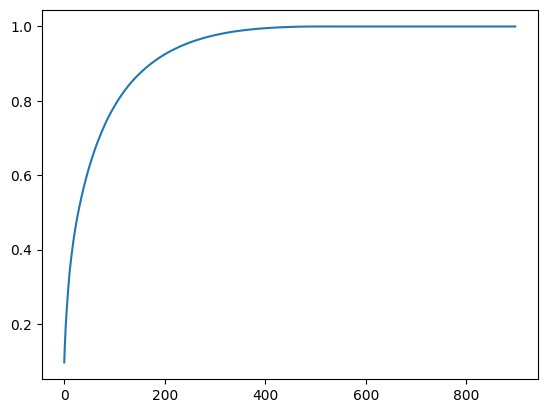

In [8]:
# Scree graph of PCA
scree_pca = PCA(n_components=898).fit(standardised_dataset)
cumulative_explained_variance = np.cumsum(scree_pca.explained_variance_ratio_)
for i, c in enumerate(cumulative_explained_variance):
    if c > 0.95:
        print(i, "components explains more than 95% of the data variance")
        no_of_features = i
        break
plt.plot(cumulative_explained_variance)



In [9]:
from sklearn.svm import SVR

X_svr = PCA(n_components=no_of_features).fit_transform(standardised_dataset)

kf = KFold(n_splits=10)

model = SVR(C=0.01, kernel="poly", gamma="auto", degree=3)

rmse_scores = []
r2_scores = []
spearman_scores = []
pearson_scores = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X_svr))):
    X_train, X_test = X_svr[train_index], X_svr[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    coeffr, _ = pearsonr(y_test, prediction)
    coeffs, _ = spearmanr(y_test, prediction)
    rmse = math.sqrt(mean_squared_error(y_test, prediction))
    r2 = r2_score(y_test, prediction)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    spearman_scores.append(coeffs)
    pearson_scores.append(coeffr)
    
print("root mean square error: ", np.array(rmse_scores).mean())
print("pearson correlation coefficient: ", np.array(pearson_scores).mean())
print("spearman correlation coefficient: ", np.array(spearman_scores).mean())
print("r2 score: ", np.array(r2_scores).mean())

10it [00:00, 13.98it/s]

root mean square error:  2.5082563210926736
pearson correlation coefficient:  0.4242164033766799
spearman correlation coefficient:  0.36928541980573815
r2 score:  0.14785139842768502


In [10]:
from xgboost import XGBRegressor

kf = KFold(n_splits=10)

model = XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

rmse_scores = []
r2_scores = []
spearman_scores = []
pearson_scores = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(dataset))):
    X_train, X_test = X_svr[train_index], X_svr[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    coeffr, _ = pearsonr(y_test, prediction)
    coeffs, _ = spearmanr(y_test, prediction)
    rmse = math.sqrt(mean_squared_error(y_test, prediction))
    r2 = r2_score(y_test, prediction)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    spearman_scores.append(coeffs)
    pearson_scores.append(coeffr)
    
print("root mean square error: ", np.array(rmse_scores).mean())
print("pearson correlation coefficient: ", np.array(pearson_scores).mean())
print("spearman correlation coefficient: ", np.array(spearman_scores).mean())
print("r2 score: ", np.array(r2_scores).mean())

10it [00:08,  1.21it/s]

root mean square error:  2.576582608002278
pearson correlation coefficient:  0.43547756818101
spearman correlation coefficient:  0.4012593643269856
r2 score:  0.11481626874283883


rmse: 2.8621180094379235    r2: -9.259538104933185e-06    spearman: 0.4931667245287939    pearson: 0.4506923558177663
rmse: 2.859112682713862    r2: -0.00026068537933321423    spearman: 0.5351300783467545    pearson: 0.4898122955913476
rmse: 2.9982791087047604    r2: -0.004086378229685161    spearman: 0.4807049158106232    pearson: 0.41835094517607024


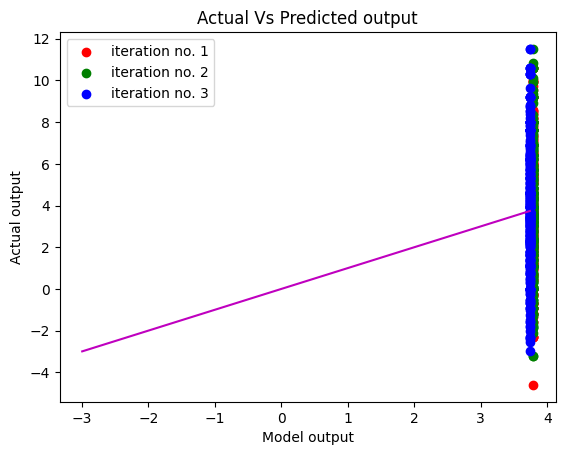



******Performance of Random Forest******
root mean square error:  2.906503266952182
pearson correlation coefficient:  0.45295186552839467
spearman correlation coefficient:  0.5030005728953905
r2 score:  -0.0014521077157077695


In [11]:
model = SVR(C=0.01, kernel="poly", gamma="auto", degree=3)

rmse_scores = []
r2_scores = []
spearman_scores = []
pearson_scores = []
colors = ['r', 'g', 'b']

for i in range(3):
    color = colors[i]
    if i == 0:
        train_dataset = fold_0 + fold_1
        val_dataset = fold_2
    elif i == 1:
        train_dataset = fold_0 + fold_2
        val_dataset = fold_1
    else:
        train_dataset = fold_1 + fold_2
        val_dataset = fold_0
    
    examples = []
    my_labels = []
    for i in range(len(train_dataset)):
        examples.append(train_dataset[i][0])
        my_labels.append(train_dataset[i][1])
    examples = np.array(examples)
    my_labels = np.array(my_labels)
    
    test_examples = []
    test_labels = []
    for i in range(len(val_dataset)):
        test_examples.append(val_dataset[i][0])
        test_labels.append(val_dataset[i][1])
    test_examples = np.array(test_examples)
    answers = np.array(test_labels)
    
    model.fit(examples, my_labels)
    outputs = model.predict(test_examples)
    coeffr, _ = pearsonr(answers, outputs)
    coeffs, _ = spearmanr(answers, outputs)
    rmse = math.sqrt(mean_squared_error(answers, outputs))
    r2 = r2_score(answers, outputs)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    spearman_scores.append(coeffs)
    pearson_scores.append(coeffr)
    print("rmse:", rmse, "  ", "r2:", r2, "  ", "spearman:", coeffs, "  ", "pearson:", coeffr)
    j = i + 2 - 300
    j = str (j)
    s = "iteration no. " + j
    plt.scatter(outputs, answers, color=color, label=s)
    if min(outputs) < min(answers):
        minimum = min(outputs)
    else:
        minimum = min(answers)
    
    if max(outputs) < max(answers):
        maximum = max(outputs)
    else:
        maximum = max(answers)
    y = np.linspace(minimum, maximum)
    x = y
    
plt.plot(x, y, color='m') # plot line y=x
plt.xlabel("Model output")
plt.ylabel("Actual output")
plt.title("Actual Vs Predicted output")
plt.legend()
plt.show()
    
print()
print()
print("******Performance of Random Forest******") 
print("root mean square error: ", np.array(rmse_scores).mean())
print("pearson correlation coefficient: ", np.array(pearson_scores).mean())
print("spearman correlation coefficient: ", np.array(spearman_scores).mean())
print("r2 score: ", np.array(r2_scores).mean())

rmse: 1.641592789508742    r2: 0.6710273295568598    spearman: 0.7868224516550276    pearson: 0.821389566242517
rmse: 1.6035212500412785    r2: 0.6853700257886755    spearman: 0.7978347772759306    pearson: 0.8290571976963619
rmse: 1.7370881572281553    r2: 0.6629683575524394    spearman: 0.7733074286763321    pearson: 0.8162175761770487


******Performance of XGBoost******
root mean square error:  1.6607340655927254
pearson correlation coefficient:  0.8222214467053092
spearman correlation coefficient:  0.7859882192024301
r2 score:  0.673121904299325
root mean square error:  1.6607340655927254
pearson correlation coefficient:  0.8222214467053092
spearman correlation coefficient:  0.7859882192024301
r2 score:  0.673121904299325
std of root mean square error:  0.056183158873215094
std of pearson correlation coefficient:  0.0052746556929076085
std of spearman correlation coefficient:  0.010030608661169126
std of r2 score:  0.009264596319877295


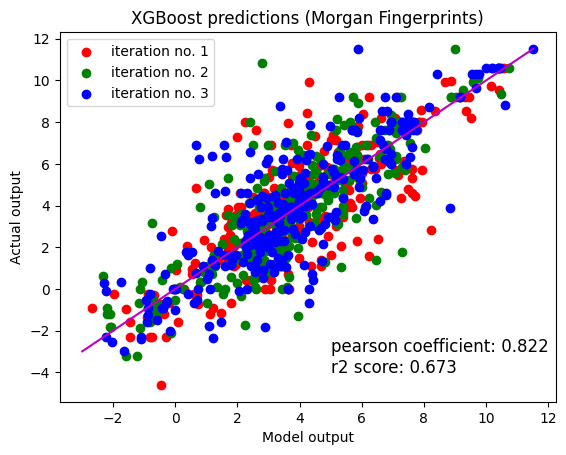

In [12]:
model = XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

rmse_scores = []
r2_scores = []
spearman_scores = []
pearson_scores = []
colors = ['r', 'g', 'b']

for i in range(3):
    color = colors[i]
    if i == 0:
        train_dataset = fold_0 + fold_1
        val_dataset = fold_2
    elif i == 1:
        train_dataset = fold_0 + fold_2
        val_dataset = fold_1
    else:
        train_dataset = fold_1 + fold_2
        val_dataset = fold_0
    
    examples = []
    my_labels = []
    for j in range(len(train_dataset)):
        examples.append(train_dataset[j][0])
        my_labels.append(train_dataset[j][1])
    examples = np.array(examples)
    my_labels = np.array(my_labels)
    
    test_examples = []
    test_labels = []
    for k in range(len(val_dataset)):
        test_examples.append(val_dataset[k][0])
        test_labels.append(val_dataset[k][1])
    test_examples = np.array(test_examples)
    answers = np.array(test_labels)
    
    model.fit(examples, my_labels)
    outputs = model.predict(test_examples)
    coeffr, _ = pearsonr(answers, outputs)
    coeffs, _ = spearmanr(answers, outputs)
    rmse = math.sqrt(mean_squared_error(answers, outputs))
    r2 = r2_score(answers, outputs)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    spearman_scores.append(coeffs)
    pearson_scores.append(coeffr)
    print("rmse:", rmse, "  ", "r2:", r2, "  ", "spearman:", coeffs, "  ", "pearson:", coeffr)
    s = "iteration no. " + str (i+1)
    plt.scatter(outputs, answers, color=color, label=s)
    if min(outputs) < min(answers):
        minimum = min(outputs)
    else:
        minimum = min(answers)
    
    if max(outputs) < max(answers):
        maximum = max(outputs)
    else:
        maximum = max(answers)
    y = np.linspace(minimum, maximum)
    x = y
    

print()
print()
print("******Performance of XGBoost******") 
print("root mean square error: ", np.array(rmse_scores).mean())
print("pearson correlation coefficient: ", np.array(pearson_scores).mean())
print("spearman correlation coefficient: ", np.array(spearman_scores).mean())
print("r2 score: ", np.array(r2_scores).mean())
print("root mean square error: ", np.array(rmse_scores).mean())
print("pearson correlation coefficient: ", np.array(pearson_scores).mean())
print("spearman correlation coefficient: ", np.array(spearman_scores).mean())
print("r2 score: ", np.array(r2_scores).mean())
print("std of root mean square error: ", np.array(rmse_scores).std())
print("std of pearson correlation coefficient: ", np.array(pearson_scores).std())
print("std of spearman correlation coefficient: ", np.array(spearman_scores).std())
print("std of r2 score: ", np.array(r2_scores).std())

plt.plot(x, y, color='m') # plot line y=x
plt.xlabel("Model output")
plt.ylabel("Actual output")
plt.title("XGBoost predictions (Morgan Fingerprints)")
plt.legend()
plt.text(5.0, -3.0, "pearson coefficient: " + str (round(np.array(pearson_scores).mean(), 3)), fontsize=12)
plt.text(5.0, -4.0, "r2 score: " + str (round(np.array(r2_scores).mean(), 3)), fontsize=12)
plt.show()


rmse: 1.6222834947208835    r2: 0.678720919759617    spearman: 0.7878987787626307    pearson: 0.8238746602729933
rmse: 1.6288396957421385    r2: 0.6753560267092388    spearman: 0.782782613179569    pearson: 0.8219047132066882
rmse: 1.7096261144074094    r2: 0.6735405504931942    spearman: 0.7879792678603185    pearson: 0.822247880676985


******Performance of Random Forest******
root mean square error:  1.653583101623477
pearson correlation coefficient:  0.8226757513855555
spearman correlation coefficient:  0.7862202199341727
r2 score:  0.67587249898735
std of root mean square error:  0.03971868078023046
std of pearson correlation coefficient:  0.0008592546647920898
std of spearman correlation coefficient:  0.0024309771386810076
std of r2 score:  0.0021461770887895265


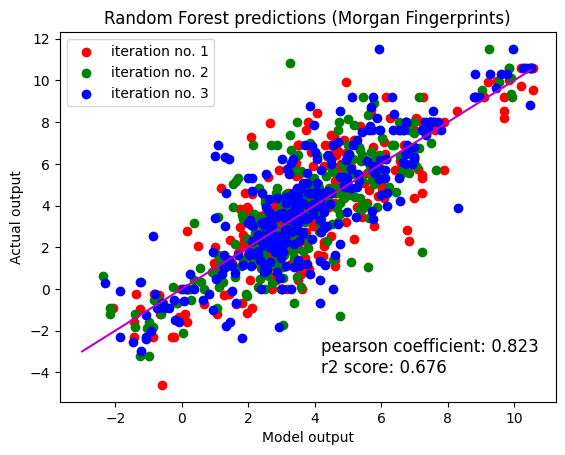

In [13]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=1000, max_depth=23, random_state=0, criterion="squared_error", max_features="sqrt")

rmse_scores = []
r2_scores = []
spearman_scores = []
pearson_scores = []
colors = ['r', 'g', 'b']

for i in range(3):
    color = colors[i]
    if i == 0:
        train_dataset = fold_0 + fold_1
        val_dataset = fold_2
    elif i == 1:
        train_dataset = fold_0 + fold_2
        val_dataset = fold_1
    else:
        train_dataset = fold_1 + fold_2
        val_dataset = fold_0
    
    examples = []
    my_labels = []
    for j in range(len(train_dataset)):
        examples.append(train_dataset[j][0])
        my_labels.append(train_dataset[j][1])
    examples = np.array(examples)
    my_labels = np.array(my_labels)
    
    test_examples = []
    test_labels = []
    for k in range(len(val_dataset)):
        test_examples.append(val_dataset[k][0])
        test_labels.append(val_dataset[k][1])
    test_examples = np.array(test_examples)
    answers = np.array(test_labels)
    
    model.fit(examples, my_labels)
    outputs = model.predict(test_examples)
    coeffr, _ = pearsonr(answers, outputs)
    coeffs, _ = spearmanr(answers, outputs)
    rmse = math.sqrt(mean_squared_error(answers, outputs))
    r2 = r2_score(answers, outputs)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    spearman_scores.append(coeffs)
    pearson_scores.append(coeffr)
    print("rmse:", rmse, "  ", "r2:", r2, "  ", "spearman:", coeffs, "  ", "pearson:", coeffr)
    s = "iteration no. " + str (i+1)
    plt.scatter(outputs, answers, color=color, label=s)
    if min(outputs) < min(answers):
        minimum = min(outputs)
    else:
        minimum = min(answers)
    
    if max(outputs) < max(answers):
        maximum = max(outputs)
    else:
        maximum = max(answers)
    y = np.linspace(minimum, maximum)
    x = y
    
print()
print()
print("******Performance of Random Forest******") 
print("root mean square error: ", np.array(rmse_scores).mean())
print("pearson correlation coefficient: ", np.array(pearson_scores).mean())
print("spearman correlation coefficient: ", np.array(spearman_scores).mean())
print("r2 score: ", np.array(r2_scores).mean())
print("std of root mean square error: ", np.array(rmse_scores).std())
print("std of pearson correlation coefficient: ", np.array(pearson_scores).std())
print("std of spearman correlation coefficient: ", np.array(spearman_scores).std())
print("std of r2 score: ", np.array(r2_scores).std())
    
plt.plot(x, y, color='m') # plot line y=x
plt.xlabel("Model output")
plt.ylabel("Actual output")
plt.title("Random Forest predictions (Morgan Fingerprints)")
plt.legend()
plt.text(4.2, -3.0, "pearson coefficient: " + str (round(np.array(pearson_scores).mean(), 3)), fontsize=12)
plt.text(4.2, -4.0, "r2 score: " + str (round(np.array(r2_scores).mean(), 3)), fontsize=12)
plt.show()
    


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 158.31it/s]


r2 score: 0.6708671994955078
spearman's rank corellation coefficient: 0.8045351833375899
pearson correlation coefficient: 0.8286962122546212
root mean squared error: 1.641992270069259


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 167.09it/s]


r2 score: 0.5491292488268975
spearman's rank corellation coefficient: 0.7512901112426478
pearson correlation coefficient: 0.7697015225515906
root mean squared error: 1.9195556338169812


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 222.41it/s]


r2 score: 0.5827342813209744
spearman's rank corellation coefficient: 0.706059367619591
pearson correlation coefficient: 0.7691992147621757
root mean squared error: 1.932826511486258


******Performance of MLP******
AVERAGE R2 SCORE: 0.6009102432144598
AVERAGE SPEARMAN RANK CORELLATION COEFFICIENT: 0.7539615540666095
AVERAGE PEARSON CORELLATION COEFFICIENT 0.7891989831894625
AVERAGE ROOT MEAN SQUARED ERROR: 1.8314581384574995
std of root mean square error:  0.13408210298572223
std of pearson correlation coefficient:  0.027929511347295228
std of spearman correlation coefficient:  0.040246937982100724
std of r2 score:  0.051334240368480014


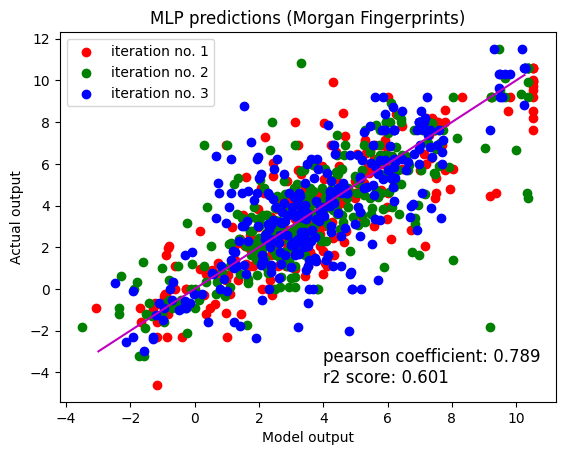

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable
USE_CUDA = torch.cuda.is_available() 

def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v


def toTensor(v,dtype = torch.float,requires_grad = False):       
    return cuda(Variable(v.clone().detach()).type(dtype).requires_grad_(requires_grad))


def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

# Hyperparameters
input_size = len(dataset[0]) #number of features
hidden_size = 250
output_size = 1
num_epochs = 1000
batch_size = 100
learning_rate = 0.0001

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fcout = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        out = self.fc1(x)
        out = self.leaky_relu(out)

        out = self.fc2(out)
        out = self.leaky_relu(out)

        out = self.fc3(out)
        out = self.tanh(out)

        out = self.fcout(out)
        return out
    
  
r2_scores = []
spearman_scores = []
pearson_scores = []
rmse_scores = []
colors = ['r', 'g', 'b']

for i in range(3):
    color = colors[i]

    if i == 0:
        train_dataset = fold_0 + fold_1
        val_dataset = fold_2
    elif i == 1:
        train_dataset = fold_0 + fold_2
        val_dataset = fold_1
    else:
        train_dataset = fold_1 + fold_2
        val_dataset = fold_0
        

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=False)
    
    model = cuda(Net(input_size, hidden_size, output_size))

    criterion = nn.MSELoss()
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
   

    model.train()

    epoch_no = []
    all_losses = []
    for j, epoch in enumerate(range(num_epochs)):
        losses = []
        for examples, my_labels in train_loader:
            examples = toTensor(examples, dtype=torch.float32)
            my_labels = toTensor(my_labels, dtype=torch.float32)
            my_labels = my_labels.unsqueeze(1)
            optimizer.zero_grad()
            output = model(examples)
            loss = criterion(output, my_labels)
            my_loss = (float) (loss)
            losses.append(my_loss)
            loss.backward()
            optimizer.step()
        losses = np.array(losses)
        epoch_no.append(j+1)
        all_losses.append(losses.sum())

    outputs = []
    answers = []
    for examples, mylabels in tqdm(val_loader):
        with torch.no_grad():
            examples = toTensor(examples, dtype=torch.float32)
            output = model(examples)
            mylabels = mylabels.unsqueeze(1)
            for o in output:
                o = float (o)
                outputs.append(o)
            for l in mylabels:
                l = float(l)
                answers.append(l)       

    outputs = np.array(outputs)
    answers = np.array(answers)
    coeffr, _ = pearsonr(answers, outputs)
    coeffs, _ = spearmanr(answers, outputs)
    rmse = math.sqrt(mean_squared_error(answers, outputs))
    r2 = r2_score(answers, outputs)
    pearson_scores.append(coeffr)
    spearman_scores.append(coeffs)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    # plot graph of actual VS predicted output
    s = "iteration no. " + str (i+1)
    plt.scatter(outputs, answers, color=color, label=s)


    print("r2 score:", r2)
    print("spearman's rank corellation coefficient:", coeffs)
    print("pearson correlation coefficient:", coeffr)
    print("root mean squared error:", rmse)
    
if min(outputs) < min(answers):
    minimum = min(outputs)
else:
    minimum = min(answers)

if max(outputs) < max(answers):
    maximum = max(outputs)
else:
    maximum = max(answers)
y = np.linspace(minimum, maximum)
x = y

r2_scores = np.array(r2_scores)
pearson_scores = np.array(pearson_scores)
spearman_scores = np.array(spearman_scores)
rmse_scores = np.array(rmse_scores)
print()
print()
print("******Performance of MLP******")
print("AVERAGE R2 SCORE:", r2_scores.mean())
print("AVERAGE SPEARMAN RANK CORELLATION COEFFICIENT:", spearman_scores.mean())
print("AVERAGE PEARSON CORELLATION COEFFICIENT", pearson_scores.mean())
print("AVERAGE ROOT MEAN SQUARED ERROR:", rmse_scores.mean())
print("std of root mean square error: ", np.array(rmse_scores).std())
print("std of pearson correlation coefficient: ", np.array(pearson_scores).std())
print("std of spearman correlation coefficient: ", np.array(spearman_scores).std())
print("std of r2 score: ", np.array(r2_scores).std())

plt.plot(x, y, color='m') # plot line y=x
plt.xlabel("Model output")
plt.ylabel("Actual output")
plt.title("MLP predictions (Morgan Fingerprints)")
plt.legend()
plt.text(4.0, -3.5, "pearson coefficient: " + str (round(np.array(pearson_scores).mean(), 3)), fontsize=12)
plt.text(4.0, -4.5, "r2 score: " + str (round(np.array(r2_scores).mean(), 3)), fontsize=12)
plt.show()


In [15]:
target_proteins = np.array(list(df["Target Protein"]))
e3_targets = np.array(list(df["E3 Target"]))
warheads = np.array(list(df["Warhead"]))
linkers = np.array(list(df["Linker"]))
e3_ligands = np.array(list(df["E3 Ligand"]))

print(target_proteins.shape)

(5372,)


In [16]:
all_target_protein_features = []
all_e3_target_features = []
all_warhead_fingerprints = []
all_e3_lignad_fingerprints = []
all_linker_fingerprints = []
for i in tqdm(range(len(target_proteins))):
    p = get_protein_features(target_proteins[i])
    et = get_protein_features(e3_targets[i])
    
    w = get_fingerprint(warheads[i])
    l = get_fingerprint(linkers[i])
    el = get_fingerprint(e3_ligands[i])
        
    all_target_protein_features.append(p)
    all_e3_target_features.append(et)
    all_warhead_fingerprints.append(w)
    all_e3_lignad_fingerprints.append(el)
    all_linker_fingerprints.append(l)
    
all_target_protein_features = np.array(all_target_protein_features)
all_e3_target_features = np.array(all_e3_target_features)
all_warhead_fingerprints = np.array(all_warhead_fingerprints)
all_e3_lignad_fingerprints = np.array(all_e3_lignad_fingerprints)
all_linker_fingerprints = np.array(all_linker_fingerprints)

print(all_target_protein_features.shape)
print(all_e3_target_features.shape)
print(all_warhead_fingerprints.shape)
print(all_e3_lignad_fingerprints.shape)
print(all_linker_fingerprints.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 5372/5372 [00:47<00:00, 112.55it/s]

(5372, 412)
(5372, 412)
(5372, 1024)
(5372, 1024)
(5372, 1024)


In [17]:
dataset = np.column_stack((all_target_protein_features, all_e3_target_features,
                           all_warhead_fingerprints, all_e3_lignad_fingerprints, all_linker_fingerprints))

print(dataset.shape)
print(dataset[0])

(5372, 3896)
[0.25865036 0.10702773 0.30770474 ... 0.         0.         0.        ]


(5372, 2)


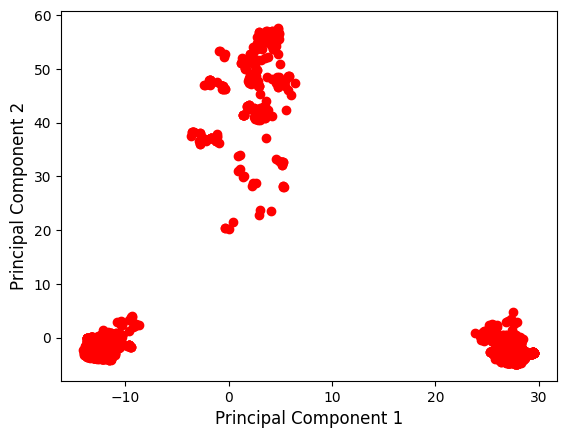

In [18]:
# standardise data
scaler = StandardScaler(with_mean=True, with_std=True)
standardised_dataset = scaler.fit_transform(dataset)

# PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(standardised_dataset)
print(X_reduced.shape)

plt.scatter(X_reduced[:,0], X_reduced[:,1], color="r", label="data")
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.show()

537 components explains more than 95% of the data variance


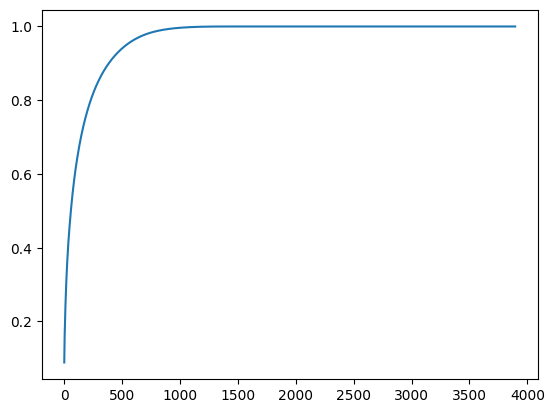

In [19]:
# Scree graph of PCA
scree_pca = PCA(n_components=3896).fit(standardised_dataset)
cumulative_explained_variance = np.cumsum(scree_pca.explained_variance_ratio_)
for i, c in enumerate(cumulative_explained_variance):
    if c > 0.95:
        print(i, "components explains more than 95% of the data variance")
        no_of_features = i
        break
plt.plot(cumulative_explained_variance)

In [20]:
indices = set(range(len(target_proteins)))
labeled_indices = set(labeled_indices)
unlabeled_indices = indices.difference(labeled_indices)
print(len(list(labeled_indices)))
print(len(list(indices)))
print(len(list(unlabeled_indices)))

903
5372
4469


In [21]:
target_proteins = np.array(list(df["Target Protein"]))
e3_targets = np.array(list(df["E3 Target"]))
warheads = np.array(list(df["Warhead"]))
linkers = np.array(list(df["Linker"]))
e3_ligands = np.array(list(df["E3 Ligand"]))

labeled_indices = list(labeled_indices)
unlabeled_indices = list(unlabeled_indices)
unlabeled_target_proteins = target_proteins[unlabeled_indices]
unlabeled_e3_targets = e3_targets[unlabeled_indices]
unlabeled_warheads = warheads[unlabeled_indices]
unlabeled_linkers = linkers[unlabeled_indices]
unlabeled_e3_ligands = e3_ligands[unlabeled_indices]
e3_ligands = e3_ligands[labeled_indices]
print(len(unlabeled_linkers))

4469


In [22]:
unlabeled_target_protein_features = []
unlabeled_e3_target_features = []
unlabeled_warhead_fingerprints = []
unlabeled_e3_lignad_fingerprints = []
unlabeled_linker_fingerprints = []
for i in tqdm(range(len(unlabeled_target_proteins))):
    p = get_protein_features(unlabeled_target_proteins[i])
    et = get_protein_features(unlabeled_e3_targets[i])
    
    w = get_fingerprint(unlabeled_warheads[i])
    l = get_fingerprint(unlabeled_linkers[i])
    el = get_fingerprint(unlabeled_e3_ligands[i])
        
    unlabeled_target_protein_features.append(p)
    unlabeled_e3_target_features.append(et)
    unlabeled_warhead_fingerprints.append(w)
    unlabeled_e3_lignad_fingerprints.append(el)
    unlabeled_linker_fingerprints.append(l)
    
unlabeled_target_protein_features = np.array(unlabeled_target_protein_features)
unlabeled_e3_target_features = np.array(unlabeled_e3_target_features)
unlabeled_warhead_fingerprints = np.array(unlabeled_warhead_fingerprints)
unlabeled_e3_lignad_fingerprints = np.array(unlabeled_e3_lignad_fingerprints)
unlabeled_linker_fingerprints = np.array(unlabeled_linker_fingerprints)

print(target_protein_features.shape)
print(e3_target_features.shape)
print(warhead_fingerprints.shape)
print(e3_lignad_fingerprints.shape)
print(linker_fingerprints.shape)

print(unlabeled_target_protein_features.shape)
print(unlabeled_e3_target_features.shape)
print(unlabeled_warhead_fingerprints.shape)
print(unlabeled_e3_lignad_fingerprints.shape)
print(unlabeled_linker_fingerprints.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 4469/4469 [00:38<00:00, 116.74it/s]

(903, 412)
(903, 412)
(903, 1024)
(903, 1024)
(903, 1024)
(4469, 412)
(4469, 412)
(4469, 1024)
(4469, 1024)
(4469, 1024)


In [23]:
test_dataset = np.column_stack((unlabeled_target_protein_features, unlabeled_e3_target_features,
                           unlabeled_warhead_fingerprints, unlabeled_e3_lignad_fingerprints, unlabeled_linker_fingerprints))

print(dataset.shape)
print(dataset[0])

(5372, 3896)
[0.25865036 0.10702773 0.30770474 ... 0.         0.         0.        ]


(4469, 2)


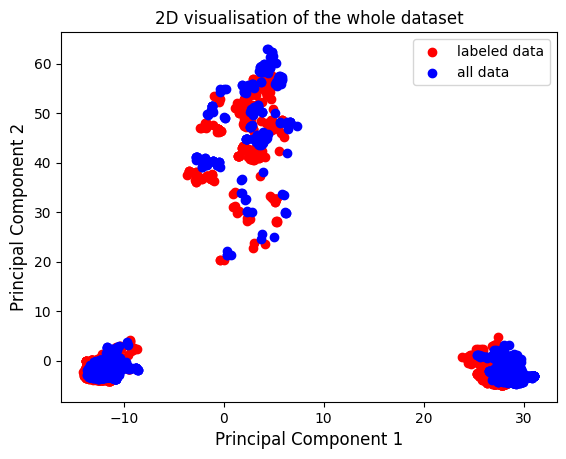

In [24]:
# standardise data
scaler = StandardScaler(with_mean=True, with_std=True)
standardised_test_dataset = scaler.fit_transform(test_dataset)

# PCA
pca = PCA(n_components=2)
test_X_reduced = pca.fit_transform(standardised_test_dataset)
print(test_X_reduced.shape)

plt.scatter(X_reduced[:,0], X_reduced[:,1], color="r", label="labeled data")
plt.scatter(test_X_reduced[:,0], test_X_reduced[:,1], color="b", label="all data")
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.title("2D visualisation of the whole dataset")
plt.legend()
plt.show()

In [25]:
def calculate_similarity(test_data, train_data):
    all_sims = []
    # selected_indices = []
    for w in tqdm(test_data):
        current_e3_ligand = get_fingerprint(w)
        min_sim = 9999
        min_index = 0
        for i in range(len(train_data)):
            to_compare = get_fingerprint(train_data[i])
            common = 0
            for bit1, bit2 in zip(current_e3_ligand, to_compare):
                if bit1 == bit2:
                    common += 1
            sim = common/1024
            if sim < min_sim:
                min_sim = sim
                min_index = int (i)
#                 selected_indices.append(i)
        all_sims.append([min_sim, min_index])
    all_sims = np.array(all_sims) 
    return all_sims

print(len(unlabeled_e3_ligands))
print(len(e3_ligands))
my_arr = calculate_similarity(unlabeled_e3_ligands, e3_ligands)

4469
903


100%|████████████████████████████████████████████████████████████████████████████| 4469/4469 [4:53:33<00:00,  3.94s/it]


In [26]:
index_of_unlabeled_protacs = list(set(my_arr[:,1]))
print(index_of_unlabeled_protacs)
index_of_protacs_of_interest = []
for idx in index_of_unlabeled_protacs:
    idx = int (idx)
    index_of_protacs_of_interest.append(unlabeled_indices[idx])
    
print(index_of_protacs_of_interest)

[161.0, 718.0, 177.0, 724.0, 245.0, 54.0, 888.0, 889.0, 251.0]
[170, 954, 186, 960, 264, 60, 1160, 1161, 271]


In [27]:
df = pd.read_csv("filtered_protacs.csv")
ids = df["Protac ID"]
test_ids = []
for i in index_of_protacs_of_interest:
    test_ids.append(ids[i])
    
print(test_ids)

[130, 649, 135, 655, 168, 30, 779, 780, 175]
